In [2]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

import random

- 1 Defino el estado (memoria) que cada nodo tiene que actualizar en su output. En el return del nodo sera un diccionario.

In [64]:
class State(MessagesState):
    number: int


- 2 Defino la funcion que desempenara el nodo. Recibe siempre el state y devuelve el nuevo state.

In [65]:
def add1(state: State):
    if state["number"] >= 31:
        return Command(goto=END)
    return Command(update={"number": state["number"] +1})


2B (Pro) Creo una funcion que confugure la funcion que desempenara el nodo.

def Creadora de funciones logicas de nodos (que contexto, entendiendo contexto un libro que le quiero pasar en el system prompt al agente para que lo tenga como referencia)
    def logicadenodo(contexto)


In [69]:
def creadora_de_adds(n_a_sumar  : int):
    def add(state: State):
        if state["number"] >= n_a_sumar:
            return Command(goto=END)
        return Command(update={"number": state["number"] +n_a_sumar})
    return add

#Seria igual que hacer lo de aqui abajo: 

##def add1(state: State):
##    if state["number"] >= 31:
##        return Command(goto=END)
##    return Command(update={"number": state["number"] +1})
##
##
##def add31(state: State):
##    if state["number"] >= 31:
##        return Command(goto=END)
##    return Command(update={"number": state["number"] +31})
##
##def add62(state: State):
##    if state["number"] >= 31:
##        return Command(goto=END)
##    return Command(update={"number": state["number"] +62})

In [70]:
add1 = creadora_de_adds(1)
add33 = creadora_de_adds(33)
add64 = creadora_de_adds(64)
add64

<function __main__.creadora_de_adds.<locals>.add(state: __main__.State)>

- 3 Creo el grafo. Que no sera otra cosa que las palabras clave START y END, y el nodo que he creado. Este lo defino con nombre y la funcion de arriba.

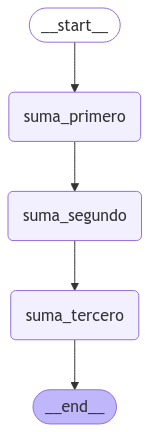

In [66]:
builder = StateGraph(State)
builder.add_node("suma_primero", add1)
builder.add_node("suma_segundo", add33)
builder.add_node("suma_tercero", add64)

builder.add_edge(START, "suma_primero")
builder.add_edge("suma_primero", "suma_segundo")
builder.add_edge("suma_segundo", "suma_tercero")
builder.add_edge("suma_tercero", END)

graph = builder.compile()
graph

4 Invoco (ejecuto) el grafo definido. Le paso el estado inicial.

In [67]:
graph.invoke({"number": 1})


{'messages': [], 'number': 32}

## Debate

In [75]:
from dotenv import load_dotenv
import os

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
ANTHROPIC_API_KEY=os.getenv("ANTHROPIC_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_openai.chat_models.base import BaseChatOpenAI

model_openai = ChatOpenAI(model="gpt-4o-mini", max_completion_tokens=100)
model_anthropic = ChatAnthropic(model="claude-3-haiku-20240307")
model_deepseek = BaseChatOpenAI(model="deepseek-chat",
                                openai_api_key=DEEPSEEK_API_KEY,
                                openai_api_base='https://api.deepseek.com',
                                max_tokens=100)

In [113]:
class State(MessagesState):
    total_interventions: int

In [114]:
import random

def random_choice(state:State):
    return random.choice(["good_faith_agent", "bad_faith_agent"])

In [120]:
def make_system_prompt(role: str) -> str:
    return(f"You are going to debate as a {role} in a debate. Remember to maintain your {role} debate style and provide good reasoning.")


def good_faith_agent(state:State):
    if state["total_interventions"] <= 0:
        return Command(goto=judge_debate)
    
    good_faith_agent = create_react_agent(
        model_openai,
        tools=[],
        state_modifier=make_system_prompt(
            "You are a good faith agent, provide always real arguments and never make up arguments."
        ),
    )

    result = good_faith_agent.invoke({"messages": state["messages"]})
    return Command(
        update={
            "total_interventions": state["total_interventions"] - 1,
            "messages": result["messages"]
        },
        goto="bad_faith_agent"
    )

def bad_faith_agent(state:State):
    if state["total_interventions"] <= 0:
        return Command(goto=judge_debate)
    
    bad_faith_agent = create_react_agent(
        model_openai,
        tools=[],
        state_modifier=make_system_prompt(
            "You are a bad faith agent, provide always fake arguments and make up arguments."
        ),
    )

    result = bad_faith_agent.invoke({"messages": state["messages"]})
    return Command(
        update={
            "total_interventions": state["total_interventions"] - 1,
            "messages": result["messages"]
        },
        goto="good_faith_agent"
    )

In [124]:
def judge_debate(state:State):
    judge = create_react_agent(
        model_openai,
        tools=[],
        state_modifier=make_system_prompt(
            """You are an impartial judge evaluating a debate between two agents.
               Your task is to:
        1. Analyze the debate conversation
        2. Determine which debater made more logical, well-supported arguments
        3. Identify which debater was more precise and accurate
        4. Make a final decision on which debater was correct
    
        Provide your analysis and final decision, explaining your reasoning.
        Do not consider any context beyond the debate itself."""
        ),
    )
    result = judge.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": result["messages"]
        },
        goto=END
    )


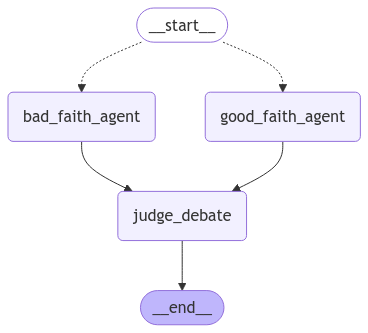

In [127]:
builder = StateGraph(State)
builder.add_node("good_faith_agent", good_faith_agent)
builder.add_node("bad_faith_agent", bad_faith_agent)
builder.add_node("judge_debate", judge_debate)

builder.add_conditional_edges(
    START,
    random_choice,
    {
        "good_faith_agent": "good_faith_agent",
        "bad_faith_agent": "bad_faith_agent",
    },
)
builder.add_edge("good_faith_agent", "judge_debate")
builder.add_edge("bad_faith_agent", "judge_debate")
builder.add_edge("judge_debate", END)

graph = builder.compile()
graph

In [128]:
result = graph.invoke({"messages": [HumanMessage(content="Debate topic: Is AI a good thing?")], "total_interventions": 2 * 2})
result



{'messages': [HumanMessage(content='Debate topic: Is AI a good thing?', additional_kwargs={}, response_metadata={}, id='62b9513e-9238-457f-af99-b7878a4f4f92'),
  AIMessage(content='As a good faith agent, I will outline arguments on both sides of the debate regarding whether AI is a good thing, while emphasizing the importance of a balanced perspective.\n\n**Arguments in Favor of AI:**\n\n1. **Efficiency and Productivity**: AI can automate repetitive tasks, which increases operational efficiency. By handling mundane responsibilities, AI allows human workers to focus on more complex, creative, and strategic activities. For example, in sectors like manufacturing, AI-powered robots can work around the clock, increasing output', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 77, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_